In [595]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from collections import Counter
from os import listdir
from os.path import isfile, join
import torch
from sklearn.model_selection import train_test_split
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

## Section 2: Naive Bayes

In [516]:
# Load files
mypath = './languageID'
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]  # all 60 files

# all classified files 0-19
docs_e = sorted([name for name in files if name.startswith("e") ]) 
docs_j = sorted([name for name in files if name.startswith("j") ])
docs_s = sorted([name for name in files if name.startswith("s") ])

In [517]:
# Split training and test data
train_e = [name for name in docs_e if not name[2].isdigit()]  # training files 0-9
train_j = [name for name in docs_j if not name[2].isdigit()]
train_s = [name for name in docs_s if not name[2].isdigit()]

test_e = [name for name in docs_e if name not in train_e]  # test files 10-19
test_j = [name for name in docs_j if name not in train_j]
test_s = [name for name in docs_s if name not in train_s]

In [590]:
def get_full_list(original_list):
    order = [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
    for i in range(len(order)):
        if i <= len(original_list)-1:
            if original_list[i][0] != order[i]:
                original_list.insert(i, (order[i], 0))
        else: 
            original_list.append((order[i], 0))    
    assert len(original_list) == 27
    return original_list

# get corpus from docs
def from_file_get_corpus(mypath, docs):
    mega_corpus_chars = ""
    for file in docs:
        file_path = join(mypath, file)
        with open(file_path) as f:
            mega_corpus_chars += f.read()
    mega_corpus_chars = mega_corpus_chars.replace('\n', '')
    total_num_char = len(mega_corpus_chars)
    cnt = Counter(mega_corpus_chars)
    sorted_cnt = sorted([(char, count) for char, count in cnt.items()]) 
    sorted_cnt = get_full_list(sorted_cnt)
#     print(sorted_cnt)
    return total_num_char, sorted_cnt

# get conditional probability of c_i given y
def get_cond_prob(mypath, docs, alpha):
    K_s  = 27
    total_num_char, sorted_cnt = from_file_get_corpus(mypath, docs)
    ans = [(tup[0],(tup[1] + alpha)/(total_num_char + K_s * alpha)) for tup in sorted_cnt]
    return ans

In [553]:
# Q2, Q3
mypath = './languageID'
alpha = 0.5
print(".....English.....")
print(get_cond_prob(mypath, train_e, alpha))
print(".....Japanese.....")
print(get_cond_prob(mypath, train_j, alpha))
print(".....Spanish.....")
print(get_cond_prob(mypath, train_s, alpha))

.....English.....
[(' ', 2712), ('a', 910), ('b', 168), ('c', 325), ('d', 332), ('e', 1594), ('f', 286), ('g', 264), ('h', 714), ('i', 838), ('j', 21), ('k', 56), ('l', 438), ('m', 310), ('n', 876), ('o', 975), ('p', 253), ('q', 8), ('r', 814), ('s', 1001), ('t', 1212), ('u', 403), ('v', 140), ('w', 234), ('x', 17), ('y', 209), ('z', 9)]
[(' ', 0.1792499586981662), ('a', 0.0601685114819098), ('b', 0.011134974392863043), ('c', 0.021509995043779945), ('d', 0.021972575582355856), ('e', 0.1053692383941847), ('f', 0.018932760614571286), ('g', 0.017478936064761277), ('h', 0.047216256401784236), ('i', 0.055410540227986124), ('j', 0.001420783082768875), ('k', 0.0037336857756484387), ('l', 0.028977366595076822), ('m', 0.020518751032545846), ('n', 0.057921691723112505), ('o', 0.06446390219725756), ('p', 0.01675202378985627), ('q', 0.0005617049396993227), ('r', 0.053824549810011564), ('s', 0.06618205848339666), ('t', 0.08012555757475633), ('u', 0.026664463902197257), ('v', 0.009284652238559392), 

In [554]:
# Q4
mypath = "./languageID"
file = "e10.txt"
file_path = join(mypath, file)
with open(file_path) as f:
            corpus_chars = f.read()
corpus_chars = corpus_chars.replace('\n', '')
cnt = Counter(corpus_chars)
sorted_cnt = sorted([(char, count) for char, count in cnt.items()])
print(sorted_cnt)

[(' ', 498), ('a', 164), ('b', 32), ('c', 53), ('d', 57), ('e', 311), ('f', 55), ('g', 51), ('h', 140), ('i', 140), ('j', 3), ('k', 6), ('l', 85), ('m', 64), ('n', 139), ('o', 182), ('p', 53), ('q', 3), ('r', 141), ('s', 186), ('t', 225), ('u', 65), ('v', 31), ('w', 47), ('x', 4), ('y', 38), ('z', 2)]


In [567]:
# Q5
def get_likelihood(mypath, train_docs, test_doc, alpha):
    total_num_char, sorted_cnt = from_file_get_corpus(mypath, test_doc)
    
    s_sorted_cnt = [item[1] for item in sorted_cnt]
    cond_probs = get_cond_prob(mypath, train_docs, alpha)
    assert len(cond_probs) == len(sorted_cnt)
    log_cond_probs = [np.log10(cond_prob[1]) for cond_prob in cond_probs]
    log_likelihood =[item[0]*item[1] for item in zip(s_sorted_cnt, log_cond_probs)] 
    return sum(log_likelihood)

alpha = 0.5
log_k_e = get_likelihood(mypath, train_e, ['e10.txt'], alpha)
log_k_j = get_likelihood(mypath, train_j, ['e10.txt'], alpha)
log_k_s = get_likelihood(mypath, train_s, ['e10.txt'], alpha)
print(".....English.....")
print(log_k_e)
print(".....Japanese.....")
print(log_k_j)
print(".....Spanish.....")
print(log_k_s)

.....English.....
-3405.6788914862113
.....Japanese.....
-3809.3849846259354
.....Spanish.....
-3677.2938684322726


In [591]:
# Q7
mypath = "./languageID"
train_order = [train_e, train_j, train_s]
alpha = 0.5

def test(mypath, train_order, test_docs,alpha):
    print(test_docs)
    result = ['e', 'j', 's']
    for test_doc in test_docs:
        order = []
        print("testing ...", test_doc)
        for train_docs in train_order:
            order.append(get_likelihood(mypath, train_docs, [test_doc], alpha))
        print(f"test doc: {test_doc}, result: {result[np.argmax(order)]}")

In [592]:
test_docs = test_e
test(mypath, train_order, test_docs, alpha)

['e10.txt', 'e11.txt', 'e12.txt', 'e13.txt', 'e14.txt', 'e15.txt', 'e16.txt', 'e17.txt', 'e18.txt', 'e19.txt']
testing ... e10.txt
test doc: e10.txt, result: e
testing ... e11.txt
test doc: e11.txt, result: e
testing ... e12.txt
test doc: e12.txt, result: e
testing ... e13.txt
test doc: e13.txt, result: e
testing ... e14.txt
test doc: e14.txt, result: e
testing ... e15.txt
test doc: e15.txt, result: e
testing ... e16.txt
test doc: e16.txt, result: e
testing ... e17.txt
test doc: e17.txt, result: e
testing ... e18.txt
test doc: e18.txt, result: e
testing ... e19.txt
test doc: e19.txt, result: e


In [585]:
test_docs = test_j
test(mypath, train_order, test_docs, alpha)

['j10.txt', 'j11.txt', 'j12.txt', 'j13.txt', 'j14.txt', 'j15.txt', 'j16.txt', 'j17.txt', 'j18.txt', 'j19.txt']
testing ... j10.txt
test doc: j10.txt, result: j
testing ... j11.txt
test doc: j11.txt, result: j
testing ... j12.txt
test doc: j12.txt, result: j
testing ... j13.txt
test doc: j13.txt, result: j
testing ... j14.txt
test doc: j14.txt, result: j
testing ... j15.txt
test doc: j15.txt, result: j
testing ... j16.txt
test doc: j16.txt, result: j
testing ... j17.txt
test doc: j17.txt, result: j
testing ... j18.txt
test doc: j18.txt, result: j
testing ... j19.txt
test doc: j19.txt, result: j


In [584]:
test_docs = test_s
test(mypath, train_order, test_docs, alpha)

['s10.txt', 's11.txt', 's12.txt', 's13.txt', 's14.txt', 's15.txt', 's16.txt', 's17.txt', 's18.txt', 's19.txt']
testing ... s10.txt
test doc: s10.txt, result: s
testing ... s11.txt
test doc: s11.txt, result: s
testing ... s12.txt
test doc: s12.txt, result: s
testing ... s13.txt
test doc: s13.txt, result: s
testing ... s14.txt
test doc: s14.txt, result: s
testing ... s15.txt
test doc: s15.txt, result: s
testing ... s16.txt
test doc: s16.txt, result: s
testing ... s17.txt
test doc: s17.txt, result: s
testing ... s18.txt
test doc: s18.txt, result: s
testing ... s19.txt
test doc: s19.txt, result: s


## Section 3: Three-layer Neural Network

In [459]:
# Q2: Implement NN from scratch
def to_one_hot(labels):
    num_labels = len(np.unique(labels))
    one_hot = np.zeros((len(labels), num_labels))
    for i, label in enumerate(labels):
        one_hot[i, label] = 1
    return one_hot

In [460]:
# Load the training and test set
train_dataset = datasets.MNIST(root='data_test', train=True, transform=None, download=True)
test_dataset = datasets.MNIST(root='data_test', train=False, transform=None, download=True)

x_train = train_dataset.data
x_train = train_dataset.data / 255 # normalize training set
y_train = train_dataset.targets
y_train = to_one_hot(y_train)

x_test = test_dataset.data
x_test = test_dataset.data / 255
y_test = test_dataset.targets
y_test = to_one_hot(y_test)

In [461]:
# Define activation functions
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def softmax(z):
    return np.exp(z) / np.sum(np.exp(z), axis=0)

# Define cross-entropy loss function
def cross_entropy_loss(y, y_hat):
    return -np.sum(y * np.log(y_hat), axis = 1).mean()

In [593]:
# Create three layer neural network architecture
class NN:     
    def __init__(self, d = 784, d1 = 300, d2 = 200, k = 10, lr = 0.5, num_epochs = 15, batch_size = 64):             
        self.W1 = np.random.randn(d1, d) / np.sqrt(d)
        self.W2 = np.random.randn(d2, d1) / np.sqrt(d1)
        self.W3 = np.random.randn(k, d2) / np.sqrt(d2)

#         self.W1 = np.zeros((d1, d)     # Initialize Wi = 0
#         self.W2 = np.zeros((d2, d1))
#         self.W3 = np.zeros((k, d2))

#         self.W1 = np.random.uniform(-1, 1, (d1, d))     # Initialize Wi = numbers generated from -1 to 1
#         self.W2 = np.random.uniform(-1, 1, (d2, d1))
#         self.W3 = np.random.uniform(-1, 1, (k, d2))

        self.lr = lr
        self.num_epochs = num_epochs
        self.batch_size = batch_size

    # Define forward and backward functions
    def inter_forward(self, x, y):
        z1 = np.dot(self.W1, x)
        a1 = sigmoid(z1)
        z2 = np.dot(self.W2, a1)
        a2 = sigmoid(z2)
        return a1.T, a2.T

    def forward(self, x, y):
        z1 = np.dot(self.W1, x)
        a1 = sigmoid(z1)
        z2 = np.dot(self.W2, a1)
        a2 = sigmoid(z2)
        z3 = np.dot(self.W3, a2)
        y_hat = softmax(z3)
        return y_hat.T # bz, cls
                           
    def save_ckpt(self, id):
        np.savez(f'{id}_weights.npz', W1=self.W1, W2=self.W2, W3=self.W3)

    def backward(self, x, y, y_hat):
        a1, a2 = self.inter_forward(x, y)
        delta4 = -(y - y_hat) # 32, 10
        dW3 = np.einsum('ij,ik->ijk', delta4, a2)
        # print('dW3 ', dW3.shape)
        # dW3 = np.dot(delta4, a2.T)
        delta3 = np.dot(delta4, self.W3) * a2 * (1 - a2) # 32, 200
        dW2 = np.einsum('ij,ik->ijk', delta3, a1) # 32, 200, 300
        # dW2 = np.dot(delta3, a1.T)
        delta2 = np.dot(delta3, self.W2) * a1 * (1 - a1)
        dW1 = np.einsum('ij,ik->ijk', delta2, x.T) # 32, 300, 784
        # dW1 = np.dot(delta2, x.T)
        # Update weights
        self.W1 -= self.lr * np.mean(dW1, axis = 0)
        self.W2 -= self.lr * np.mean(dW2, axis = 0)
        self.W3 -= self.lr * np.mean(dW3, axis = 0)

In [478]:
# Training loop
def neural_network_minibatch_train(nn, x_train, y_train, x_test, y_test, batch_size, lr, num_epochs, d, save = False, id = None):
    num_train_batches = len(x_train) // batch_size
    training_loss = []
    test_loss = []
    for epoch in range(num_epochs):
#         running_loss = 0.0
        train_correct = 0
        epoch_train_loss = 0
        epoch_test_loss = 0
        for i in range(num_train_batches):
            # Load batch
            idx = range(i*batch_size, (i+1)*batch_size)
            batch_x = np.reshape(x_train[idx], (batch_size, d))
            batch_y = np.array(y_train[idx])
            
            # print(batch_x.shape) # 32, 784
            # print(batch_y.shape) # 32, 10

            # Forward pass
            y_hat = nn.forward(batch_x.T, batch_y)
            # print(y_hat)
            loss = cross_entropy_loss(batch_y, y_hat)
#             running_loss += loss * batch_size

            # Compute accuracy
            predictions = np.argmax(y_hat, axis=1)
            true_labels = np.argmax(batch_y, axis=1)
            train_correct += np.sum(predictions == true_labels)

            # Backward pass
            nn.backward(batch_x.T, batch_y, y_hat)
            
#             # Running loss and average accuracy
#             if i % 50 == 49: 
#                 avg_loss = running_loss / (50*batch_size)
#                 avg_correct = train_correct / (50*batch_size)
#                 print(f'Epoch {epoch+1}, Iter {i+1}, Average Loss: {avg_loss:.4f}, Avg acc: {avg_correct:.4f}')
#                 running_loss = 0.0
#                 train_correct = 0
                
            # store and print epoch training loss and accuracy
            epoch_train_loss += loss * batch_size
        epoch_train_loss /= (num_train_batches * batch_size)
        epoch_train_accuracy = train_correct / (num_train_batches * batch_size)
        training_loss.append(epoch_train_loss)
        print(f"Epoch: {epoch+1}/{num_epochs}, Training loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_accuracy:.4f}")
        
        # store and print epoch test loss and accuracy
        epoch_test_loss, epoch_test_accuracy = neural_network_minibatch_test(nn, x_test, y_test, batch_size, lr, d)
        test_loss.append(epoch_test_loss)
    
    if save:
        nn.save_ckpt(id)
    return training_loss, test_loss


In [464]:
 def plot_learning_curve(num_epochs, training_loss, test_loss):
    plt.plot(range(1, num_epochs + 1), training_loss, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), test_loss, label='Test Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Learning Curve")
    plt.legend()
    plt.show()

In [503]:
lr = 0.5
batch_size = 64
num_epochs = 15
d = 784
nn = NN(lr = lr, batch_size = batch_size)
training_loss_64, test_loss_64 = neural_network_minibatch_train(nn, x_train, y_train, x_test, y_test, batch_size, lr, num_epochs, d)

Epoch: 1/15, Training loss: 0.6727, Training Accuracy: 0.7814
Test Loss: 0.3585, Test Accuracy: 0.8882
Epoch: 2/15, Training loss: 0.2818, Training Accuracy: 0.9168
Test Loss: 0.2620, Test Accuracy: 0.9179
Epoch: 3/15, Training loss: 0.2157, Training Accuracy: 0.9358
Test Loss: 0.2050, Test Accuracy: 0.9365
Epoch: 4/15, Training loss: 0.1727, Training Accuracy: 0.9485
Test Loss: 0.1693, Test Accuracy: 0.9482
Epoch: 5/15, Training loss: 0.1432, Training Accuracy: 0.9575
Test Loss: 0.1450, Test Accuracy: 0.9546
Epoch: 6/15, Training loss: 0.1215, Training Accuracy: 0.9640
Test Loss: 0.1275, Test Accuracy: 0.9597
Epoch: 7/15, Training loss: 0.1047, Training Accuracy: 0.9695
Test Loss: 0.1147, Test Accuracy: 0.9634
Epoch: 8/15, Training loss: 0.0911, Training Accuracy: 0.9735
Test Loss: 0.1049, Test Accuracy: 0.9660
Epoch: 9/15, Training loss: 0.0799, Training Accuracy: 0.9773
Test Loss: 0.0972, Test Accuracy: 0.9685
Epoch: 10/15, Training loss: 0.0704, Training Accuracy: 0.9800
Test Loss:

[0.672712590750058, 0.28177384423694063, 0.215668208596046, 0.1727370744279292, 0.14318470874256348, 0.1214512937606302, 0.10467659322830623, 0.09113903472814312, 0.07989858715938314, 0.07043859792211186, 0.06235116963311081, 0.05532065649646682, 0.049121327552375645, 0.043595266437736487, 0.03863202614947533] [0.3584511041746361, 0.26204671577627325, 0.20502700739019927, 0.1693381514071508, 0.14500839914129232, 0.12751992644625645, 0.11468295470388257, 0.10494561686127536, 0.0972314103498255, 0.09110904796891174, 0.08656134985407493, 0.0834852648903961, 0.0814607995859231, 0.08000988688679746, 0.07877304103501591]


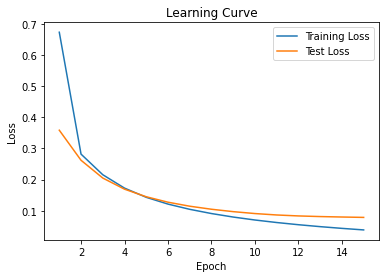

In [504]:
# Plot learning curve given batch size = 64, learning rate = 0.5, number of epochs = 15
print(training_loss_64, test_loss_64)
plot_learning_curve(num_epochs, training_loss = training_loss_64, test_loss = test_loss_64)

In [497]:
# Q4
# Initialize weights to 0, given batch size = 64, learning rate = 0.5, number of epochs = 15
lr = 0.5
batch_size = 64
num_epochs = 15
d = 784
nn0 = NN(lr = lr, batch_size = batch_size)
training_loss_i0, test_loss_i0 = neural_network_minibatch_train(nn0, x_train, y_train, x_test, y_test, batch_size, lr, num_epochs, d)

Epoch: 1/15, Training loss: 0.6670, Training Accuracy: 0.7854
Test Loss: 0.3560, Test Accuracy: 0.8881
Epoch: 2/15, Training loss: 0.2758, Training Accuracy: 0.9182
Test Loss: 0.2565, Test Accuracy: 0.9207
Epoch: 3/15, Training loss: 0.2112, Training Accuracy: 0.9369
Test Loss: 0.1991, Test Accuracy: 0.9390
Epoch: 4/15, Training loss: 0.1688, Training Accuracy: 0.9502
Test Loss: 0.1635, Test Accuracy: 0.9502
Epoch: 5/15, Training loss: 0.1396, Training Accuracy: 0.9585
Test Loss: 0.1398, Test Accuracy: 0.9576
Epoch: 6/15, Training loss: 0.1181, Training Accuracy: 0.9651
Test Loss: 0.1232, Test Accuracy: 0.9611
Epoch: 7/15, Training loss: 0.1014, Training Accuracy: 0.9700
Test Loss: 0.1114, Test Accuracy: 0.9649
Epoch: 8/15, Training loss: 0.0879, Training Accuracy: 0.9743
Test Loss: 0.1027, Test Accuracy: 0.9684
Epoch: 9/15, Training loss: 0.0767, Training Accuracy: 0.9782
Test Loss: 0.0963, Test Accuracy: 0.9704
Epoch: 10/15, Training loss: 0.0673, Training Accuracy: 0.9809
Test Loss:

[0.6670203054777928, 0.2758341853281295, 0.2111812543795634, 0.1688390999700045, 0.13964845861187827, 0.11811866529725365, 0.10138145300460057, 0.08786818053233961, 0.07669486924096829, 0.06733338848860003, 0.059378397037373826, 0.05250774303685015, 0.04648513292434168, 0.041150191980915136, 0.03639527631104327] [0.35597919574630044, 0.256501779540454, 0.19913578719970237, 0.16347857884168263, 0.13980834625203548, 0.12322685625713543, 0.11138664284525664, 0.10270964299135692, 0.09626836128972036, 0.09151953879673706, 0.08805809358138832, 0.08548926301071928, 0.0835434063537732, 0.08208840860691516, 0.0810403436033596]


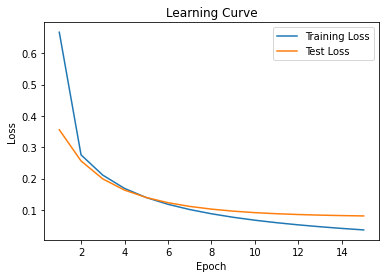

In [498]:
print(training_loss_i0, test_loss_i0)
plot_learning_curve(num_epochs, training_loss = training_loss_i0, test_loss = test_loss_i0)

In [500]:
# Initialize weights to randomly generated between -1 to 1, given batch size = 64, learning rate = 0.5, number of epochs = 15
lr = 0.5
batch_size = 64
num_epochs = 15
d = 784
nn1 = NN(lr = lr, batch_size = batch_size)
training_loss_i1, test_loss_i1 = neural_network_minibatch_train(nn1, x_train, y_train, x_test, y_test, batch_size, lr, num_epochs, d)

Epoch: 1/15, Training loss: 0.5244, Training Accuracy: 0.8603
Test Loss: 0.2818, Test Accuracy: 0.9145
Epoch: 2/15, Training loss: 0.2073, Training Accuracy: 0.9375
Test Loss: 0.2077, Test Accuracy: 0.9363
Epoch: 3/15, Training loss: 0.1526, Training Accuracy: 0.9548
Test Loss: 0.1807, Test Accuracy: 0.9447
Epoch: 4/15, Training loss: 0.1202, Training Accuracy: 0.9648
Test Loss: 0.1644, Test Accuracy: 0.9501
Epoch: 5/15, Training loss: 0.0974, Training Accuracy: 0.9719
Test Loss: 0.1549, Test Accuracy: 0.9527
Epoch: 6/15, Training loss: 0.0802, Training Accuracy: 0.9777
Test Loss: 0.1490, Test Accuracy: 0.9539
Epoch: 7/15, Training loss: 0.0666, Training Accuracy: 0.9819
Test Loss: 0.1442, Test Accuracy: 0.9564
Epoch: 8/15, Training loss: 0.0555, Training Accuracy: 0.9862
Test Loss: 0.1398, Test Accuracy: 0.9569
Epoch: 9/15, Training loss: 0.0464, Training Accuracy: 0.9891
Test Loss: 0.1361, Test Accuracy: 0.9593
Epoch: 10/15, Training loss: 0.0390, Training Accuracy: 0.9916
Test Loss:

[0.5244388838715024, 0.20732162266294138, 0.15264742906322762, 0.12023142445975721, 0.0974360702013024, 0.08021804412992231, 0.06657650788366483, 0.0554967699708923, 0.046426241168097584, 0.038999460937228385, 0.032909802728184084, 0.027906147732163218, 0.023794835771803895, 0.020410918086654007, 0.017615412887825335] [0.281843876591885, 0.20768987722958307, 0.18072840190215902, 0.1644318187114422, 0.1548622472710574, 0.1489613687301465, 0.14420269879510586, 0.13981753533837243, 0.1360987591659683, 0.13321251462210595, 0.131118879482028, 0.12964794131671167, 0.12861947316104386, 0.12792350851968934, 0.12748202496937297]


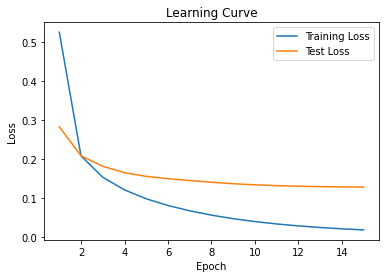

In [501]:
print(training_loss_i1, test_loss_i1)
plot_learning_curve(num_epochs, training_loss = training_loss_i1, test_loss = test_loss_i1)

In [481]:
# Plot learning curve given batch size = 32, learning rate = 0.5, number of epochs = 15
lr = 0.5
batch_size = 32
num_epochs = 15
d = 784
nn = NN(lr = lr, batch_size = batch_size)
training_loss_32, test_loss_32 = neural_network_minibatch_train(nn, x_train, y_train, x_test, y_test, batch_size, lr, num_epochs, d)

Epoch: 1/15, Training loss: 0.5137, Training Accuracy: 0.8342
Test Loss: 0.2620, Test Accuracy: 0.9195
Epoch: 2/15, Training loss: 0.2056, Training Accuracy: 0.9377
Test Loss: 0.1763, Test Accuracy: 0.9470
Epoch: 3/15, Training loss: 0.1448, Training Accuracy: 0.9559
Test Loss: 0.1358, Test Accuracy: 0.9590
Epoch: 4/15, Training loss: 0.1105, Training Accuracy: 0.9667
Test Loss: 0.1135, Test Accuracy: 0.9654
Epoch: 5/15, Training loss: 0.0879, Training Accuracy: 0.9743
Test Loss: 0.1008, Test Accuracy: 0.9697
Epoch: 6/15, Training loss: 0.0717, Training Accuracy: 0.9793
Test Loss: 0.0933, Test Accuracy: 0.9700
Epoch: 7/15, Training loss: 0.0591, Training Accuracy: 0.9832
Test Loss: 0.0900, Test Accuracy: 0.9714
Epoch: 8/15, Training loss: 0.0489, Training Accuracy: 0.9864
Test Loss: 0.0893, Test Accuracy: 0.9710
Epoch: 9/15, Training loss: 0.0405, Training Accuracy: 0.9891
Test Loss: 0.0889, Test Accuracy: 0.9719
Epoch: 10/15, Training loss: 0.0334, Training Accuracy: 0.9914
Test Loss:

[0.5137242314309469, 0.20562265954203765, 0.14484872153108638, 0.11047873819337217, 0.08790630150487384, 0.07169251494585582, 0.059060084460478265, 0.0488716387625614, 0.040480088065147454, 0.03339845089306827, 0.02735100429509918, 0.0221906145593336, 0.017809800342587195, 0.014259681276340629, 0.011429296892943416] [0.2619654564671687, 0.17634700977971088, 0.13580430104976862, 0.11354785568817452, 0.10076331727390261, 0.09331292151558286, 0.09002240061526817, 0.0892840055895494, 0.08887294279554087, 0.08733075305254166, 0.08515035302106348, 0.08369935979220791, 0.08326541378314184, 0.08446320259888769, 0.08537665401958905]


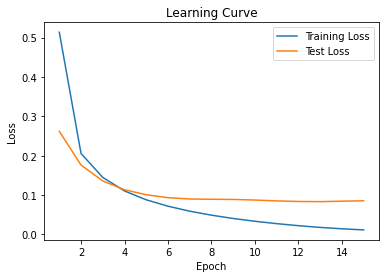

In [482]:
print(training_loss_32, test_loss_32)
plot_learning_curve(num_epochs, training_loss = training_loss_32, test_loss = test_loss_32)

In [480]:
# Compute test loss and accuracy
def neural_network_minibatch_test(nn, x_test, y_test, batch_size, lr, d):
    num_test_batches = len(x_test) // batch_size
    test_loss = 0.0
    test_correct = 0
    for i in range(num_test_batches):
        # Load batch
        idx = range(i*batch_size, (i+1)*batch_size)
        batch_x = np.reshape(x_test[idx], (batch_size, d))
        batch_y = np.array(y_test[idx])

        # Forward pass
        y_hat = nn.forward(batch_x.T, batch_y)
        # print(y_hat)
        loss = cross_entropy_loss(batch_y, y_hat)
        test_loss += loss * batch_size

        # Compute accuracy
        predictions = np.argmax(y_hat, axis=1)
        true_labels = np.argmax(batch_y, axis=1)
        test_correct += np.sum(predictions == true_labels)
    test_accuracy = test_correct / (num_test_batches * batch_size)
    test_loss = test_loss / (num_test_batches * batch_size)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    return test_loss, test_accuracy


In [420]:
test_loss, test_accuracy = neural_network_minibatch_test(nn, x_test, y_test, batch_size, lr, d)

Test Loss: 0.0808, Test Accuracy: 0.9721


Epoch 1/15, Train Loss: 2.2507, Test Loss: 2.1167
Epoch 2/15, Train Loss: 1.9510, Test Loss: 1.8441
Epoch 3/15, Train Loss: 1.8141, Test Loss: 1.7756
Epoch 4/15, Train Loss: 1.7463, Test Loss: 1.7286
Epoch 5/15, Train Loss: 1.7213, Test Loss: 1.7188
Epoch 6/15, Train Loss: 1.7116, Test Loss: 1.7095
Epoch 7/15, Train Loss: 1.7059, Test Loss: 1.7045
Epoch 8/15, Train Loss: 1.7021, Test Loss: 1.7032
Epoch 9/15, Train Loss: 1.6988, Test Loss: 1.7010
Epoch 10/15, Train Loss: 1.6964, Test Loss: 1.6982
Epoch 11/15, Train Loss: 1.6943, Test Loss: 1.6959
Epoch 12/15, Train Loss: 1.6921, Test Loss: 1.6967
Epoch 13/15, Train Loss: 1.6907, Test Loss: 1.6942
Epoch 14/15, Train Loss: 1.6893, Test Loss: 1.6941
Epoch 15/15, Train Loss: 1.6876, Test Loss: 1.6931


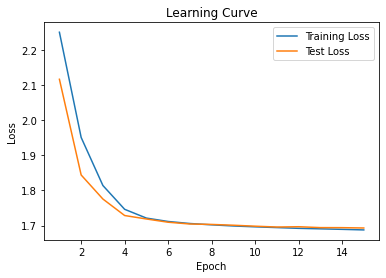

In [485]:
# Q3
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Define the neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 300)
        self.fc2 = nn.Linear(300, 200)
        self.fc3 = nn.Linear(200, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return torch.softmax(x, dim=1)

model = Net()

# Set the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.5)

# Train and test the model, store training and test loss  
num_epochs = 15
training_loss = []
test_loss = []
for epoch in range(num_epochs):
    # Training
    model.train()
    epoch_train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    epoch_train_loss /= len(train_loader)
    training_loss.append(epoch_train_loss)

    # Testing
    model.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            loss = criterion(output, target)
            epoch_test_loss += loss.item()
    epoch_test_loss /= len(test_loader)
    test_loss.append(epoch_test_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")

# Plot the learning curve
plt.plot(range(1, num_epochs + 1), training_loss, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_loss, label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.show()